In [79]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import numba as nb
from numba import njit, prange
from numba.experimental import jitclass
import pickle

from mpmath import *
mp.dps = 200;mp.pretty = True
import tomllib
from pip._vendor import tomli
import sys, os
from joblib import Parallel, delayed
import multiprocess as mp
from concurrent.futures import ProcessPoolExecutor
import scipy as sp
from scipy import *
import faulthandler
faulthandler.enable()
sys.path.append('./code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats  

import math as mp
import timeit
import time

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
import time
from iminuit.util import describe
from typing import Annotated

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

iminuit version: 2.30.1


In [80]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis
#------------------------------------------------------------------------------------------------------------------------------------------

with open('ini_files/W_analysis_L20_xi=1_pole.toml', "rb") as f:
    params = tomli.load(f)

with open('ini_files/basic_setup_pole.toml', "rb") as f2:
    params2 = tomli.load(f2)

for i in params:
     params['{}'.format(i)].update(params2['{}'.format(i)])


who            = params['creator']['who']
  
  
path           = params['paths_to_files']['base_path']
mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
sizelabel      = params['paths_to_files']['sizelabel']      
  
  
corrtype       = params['correlators']['corrtype']  
xi             = params['correlators']['xi']
beta           = params['correlators']['beta']
betanorm       = params['correlators']['betanorm']
Lextent        = params['correlators']['Lextent']
Textent        = params['correlators']['Textent']
size           = params['correlators']['size']
Ncfgs          = params['correlators']['Ncfgs']

als            = params['correlators']['als']
  
dini_Gc        = params['minimization_parameters']['dini_Gc']
dstop_Gc       = params['minimization_parameters']['dstop_Gc']
dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
dini_Vr        = params['minimization_parameters']['dini_Vr']
dstop_Vr       = params['minimization_parameters']['dstop_Vr']
dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
dfin_Gc        = params['minimization_parameters']['dfin_Gc']
dfin_Vr        = params['minimization_parameters']['dfin_Vr']
reuse          = params['minimization_parameters']['reuse']
inv_first      = params['minimization_parameters']['inv_first']
mcalls         = params['minimization_parameters']['mcalls']
mtol           = params['minimization_parameters']['mtol']
inipars_Gc     = params['minimization_parameters']['inipars_GC']
variants_Gc    = params['minimization_parameters']['variants_GC']
jackkl         = params['minimization_parameters']['jackkl']
xiini          = params['minimization_parameters']['xiini']
xifin          = params['minimization_parameters']['xifin']   
fileini        = params['minimization_parameters']['fileini']                         
filefin        = params['minimization_parameters']['filefin']
datatype_Gc    = params['minimization_parameters']['datatype_Gc']
model_Gc       = params['minimization_parameters']['model_Gc']
model_Vr       = params['minimization_parameters']['model_Vr']
datatype_Vr    = params['minimization_parameters']['datatype_Vr']
inipars_Vr     = params['minimization_parameters']['inipars_Vr']
variants_Vr    = params['minimization_parameters']['variants_Vr']
multiprocess   = params['minimization_parameters']['multiprocess']
cov_freeze     = params['minimization_parameters']['cov_freeze']
improve        = params['minimization_parameters']['improve']
multistart     = params['minimization_parameters']['multistart']
  

clean          = params['extra']['clean']
cutoff_ma      = params['extra']['cutoff_ma']
norm           = params['extra']['norm']
no_corrs       = params['extra']['no_corrs']
no_valid_check = params['extra']['no_valid_check']


gev_m1_tofm=5.068
als=np.array(als)/gev_m1_tofm
als_orig=np.array(als)*gev_m1_tofm

In [81]:
#------------------------------------------------------------------------------------------------------------------------------------------
#This is the only part that varies between Sebastian's and Wyatt's Lattices, the paths/readings
#------------------------------------------------------------------------------------------------------------------------------------------

# Create results folders if they do not exist
if os.path.exists(resultsdir)==False:
    os.mkdir(resultsdir)
if os.path.exists(plotsdir)==False:
    os.mkdir(plotsdir)
if os.path.exists(Gcplotsdir)==False:
    os.mkdir(Gcplotsdir)    


# Clean results folder?
if clean == 1:
    os.system('rm -rf {}/*'.format(plotsdir))
    os.system('rm -rf {}/*'.format(resultsdir))  
    os.system('rm -rf {}/*'.format(Gcplotsdir)) 


for k in range(len(xi)):
    if os.path.exists('{}{}'.format(resultspath,xi[k]))==False:
        os.mkdir('{}{}'.format(resultspath,xi[k]))
    if os.path.exists('{}/xi={}'.format(Gcplotsdir,xi[k]))==False:
        os.mkdir('{}/xi={}'.format(Gcplotsdir,xi[k]))

        
#------------------------------------------------------------------------------------------------------------------------------------------
# Read raw data and prepare accordingly
#------------------------------------------------------------------------------------------------------------------------------------------
         

# Data used in the analysis
datam=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(beta)):
        dataint.append(np.genfromtxt('{}{}/L{}_b{}_xi{}_{}.dat'.format(mainpath,xi[k],int(sizelabel),beta[j],xi[k],corrtype)))
    datam.append(dataint)
    
# Collect completed configurations from raw data    
data=[]
for k in range(len(xi)):
    dataint=[]
    for j in range(len(datam[k])):
        if (len(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))==0):
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_W()))
        else:
            dataint.append(np.array(collect_configs(datam[k][j],Lextent,Textent).trans_S()))
    data.append(dataint)

      

nconfigs=[]
for k in range(len(xi)):
    nint=[]
    for j in range(len(beta)):
        nint.append(int(len(data[k][j])/size[k]))
        print(int(len(data[k][j])/size[k]))
        nconfigs.append(int(len(data[k][j])/size[k]))  

print(min(nconfigs),max(nconfigs))  
print(beta)

400
400 400
[611]


<>:68: SyntaxWarning: invalid escape sequence '\,'
<>:68: SyntaxWarning: invalid escape sequence '\,'
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_20403/3289462132.py:68: SyntaxWarning: invalid escape sequence '\,'
  '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm),
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_20403/3289462132.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12,frameon=False,loc=0)


Text(0.4, 0.8, '$L=20,\\, \\beta=6.11$')

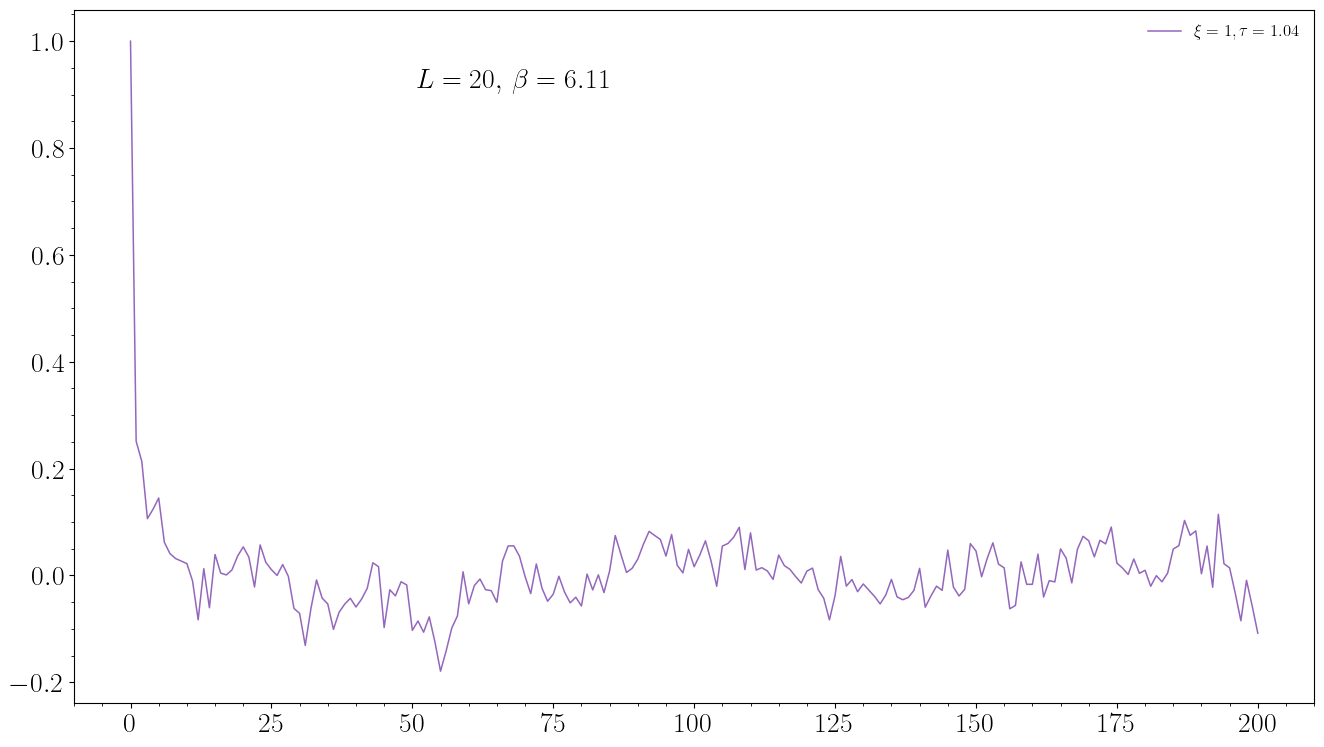

In [82]:
# Testing autocorrelations, based on page 94 from Gattringer and Lang's and page 184 of Degrand and Detar

def auto_func(t,a,b):
    return a*np.exp(-t/b)

def autocorr(list,dt):
    mean=np.mean(list)
    mean1=0
    mean2=0
    Ncfgs=len(list)
    corr1=0
    corr2=0
    for i in range(Ncfgs-dt):
        corr1+=(list[i]*list[i+dt])/(Ncfgs-dt)
        corr2+=(list[i]-mean)*(list[i+dt]-mean)/(Ncfgs-dt)
        mean1+=list[i]/(Ncfgs-dt)
        mean2+=list[i+dt]/(Ncfgs-dt)
    
    corr1-=mean1*mean2
    return corr2

xi_range=1
r_range=5
r_ini=1
tval=5
t_ini=1
ergodic_T=200

for beta_label in range(len(beta)):

    fig = plt.figure(figsize=(16,9))
    plt.legend(fontsize=12,frameon=False,loc=0)

    for x in range(xi_range):
        corr_ergodic_final=[]

        jump_configs=1
        #print(len(data[x][beta_label]))
        totaltraj=int(len(data[x][beta_label])/size[beta_label])
        Nt=Textent
        Gc=np.zeros((int(totaltraj/jump_configs),Nt))

        for r in range(r_ini,r_ini+r_range):
            for i in range(int(totaltraj/jump_configs)):
                index=jump_configs*i
                Gc[[i]]=data[x][beta_label][range(index*Nt,(index+1)*Nt),[r]]

            data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
            corr_ergodic=[]
            for i in data_ergodic:
                inter=0
                for k in range(t_ini,t_ini+tval):
                     inter+=autocorr(Gc[:,k],int(i))/autocorr(Gc[:,k],0)/tval

                corr_ergodic.append(inter)

            corr_ergodic_final.append(corr_ergodic)

        final_autocor=np.mean(corr_ergodic_final,axis=0)
        fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
        time_autoco=fit_autocor[0][1]

        plt.plot(data_ergodic, final_autocor, label='$\\xi={},\\tau={:10.2f}$'.format(x+1,time_autoco),color=jpac_color_around[x])
        plt.legend(fontsize=12,frameon=False,loc=1)
        #plt.plot(data_ergodic, auto_func(data_ergodic,fit_autocor[0][0],fit_autocor[0][1]), label="fit",color="blue")

    plt.figtext(0.4, 0.8, 
                '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 20,  
                color ="black")
    plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\,'
<>:47: SyntaxWarning: invalid escape sequence '\,'
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_20403/2611096837.py:47: SyntaxWarning: invalid escape sequence '\,'
  '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm),
/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_20403/2611096837.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12,frameon=False,loc=0)


Text(0.4, 0.8, '$L=20,\\, \\beta=6.11$')

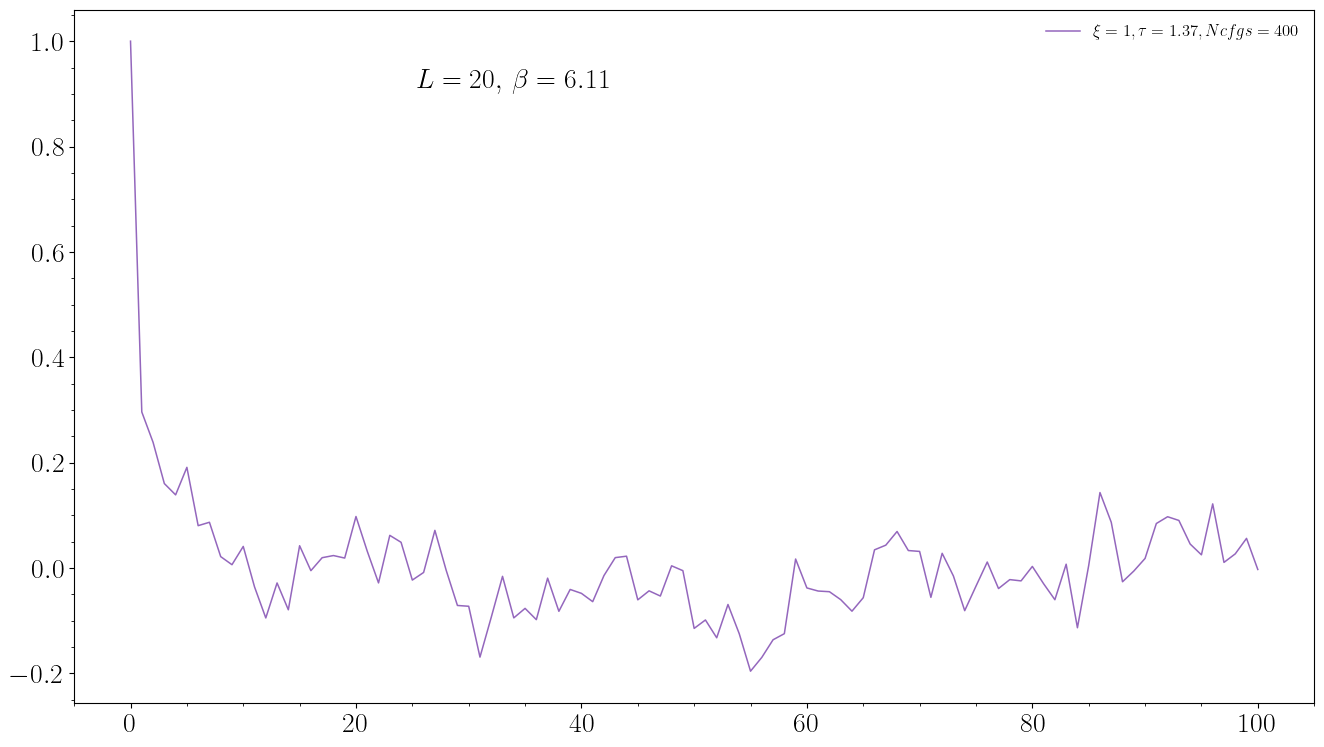

In [83]:
xi_range=1
r_range=5
r_ini=1
tval=1
t_ini=1
ergodic_T=100

for beta_label in range(0,1+0*len(beta)):

    fig = plt.figure(figsize=(16,9))
    plt.legend(fontsize=12,frameon=False,loc=0)

    for x in range(xi_range):
        jump_configs=1
        #print(len(data[x][beta_label]))
        totaltraj=int(len(data[x][beta_label])/size[beta_label])
        Nt=Textent
        Gc=np.zeros((totaltraj,Nt))
        Gc_avg=np.zeros(totaltraj)

        for i in range(totaltraj):
            for r in range(r_ini,r_ini+r_range):
                index=jump_configs*i
                Gc[[i]]+=data[x][beta_label][range(index*Nt,(index+1)*Nt),[r]]/r_range

            for k in range(t_ini,t_ini+tval):
                Gc_avg[[i]]+=Gc[i,k]/tval
                

        data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
        corr_ergodic=[]
        corr_ergodic_final=[]
        for i in data_ergodic:
            inter=autocorr(Gc_avg,int(i))/autocorr(Gc_avg,0)
            corr_ergodic.append(inter)
        corr_ergodic_final.append(corr_ergodic)

        final_autocor=np.mean(corr_ergodic_final,axis=0)
        fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
        time_autoco=fit_autocor[0][1]

        plt.plot(data_ergodic, final_autocor, label='$\\xi={},\\tau={:10.2f},Ncfgs={}$'.format(x+1,time_autoco,totaltraj),color=jpac_color_around[x])
        plt.legend(fontsize=12,frameon=False,loc=1)
        #plt.plot(data_ergodic, auto_func(data_ergodic,fit_autocor[0][0],fit_autocor[0][1]), label="fit",color="blue")

    plt.figtext(0.4, 0.8, 
                '$L={},\, \\beta={}$'.format(sizelabel,beta[beta_label]/betanorm), 
                horizontalalignment ="center",  
                verticalalignment ="center",  
                wrap = True, fontsize = 20,  
                color ="black")
    plt.show()

/var/folders/6f/lpqhbvqs49j3w6hj241yz3880000gn/T/ipykernel_20403/3298399922.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12,frameon=False,loc=0)


NameError: name 'data_test' is not defined

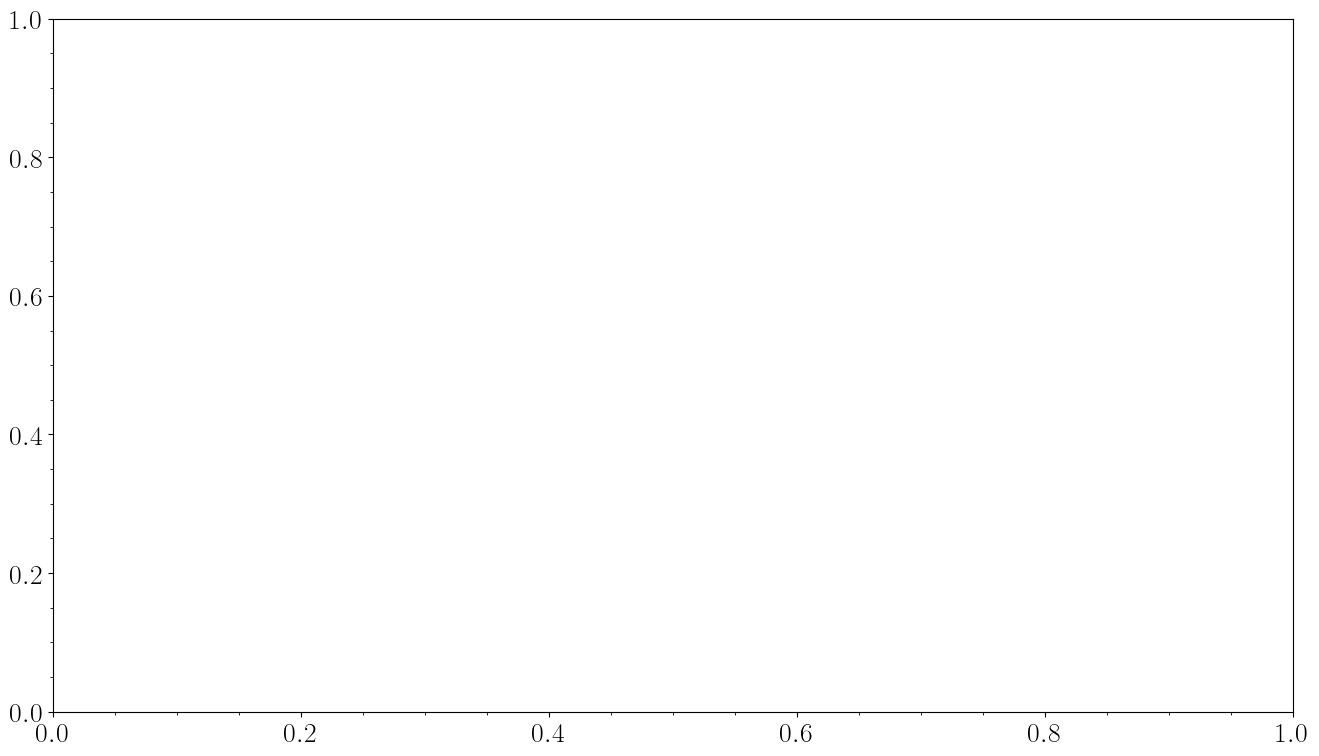

In [84]:
#data_test=np.genfromtxt('../tests/Arkaitz-2.75.dat')[:20

fig = plt.figure(figsize=(16,9))
plt.legend(fontsize=12,frameon=False,loc=0)

ergodic_T=80
data_ergodic   = np.linspace(0, ergodic_T, ergodic_T+1)
corr_ergodic=[]
corr_ergodic_final=[]
for i in data_ergodic:
    inter=autocorr(data_test[:],int(i))/autocorr(data_test[:],0)
    corr_ergodic.append(inter)

corr_ergodic_final.append(corr_ergodic)

final_autocor=corr_ergodic_final[0]
fit_autocor=sp.optimize.curve_fit(auto_func,data_ergodic,final_autocor)
time_autoco=fit_autocor[0][1]
plt.scatter(data_ergodic, final_autocor, label='$\\beta=2.75,\\tau={:10.2f}$'.format(time_autoco),color=jpac_color_around[x])
plt.legend(fontsize=12,frameon=False,loc=1)

plt.show()